# Redes Adversárias Generativas (GANs)

Vamos aprender a aplicar as Redes Adversárias Generativas (GANs)? Vamos utilizar a clássica base de dados MNIST. Esse dataset é disponibilizado pelo Keras e consistem em imagens de treinamento e imagens de teste para classificar dígitos escritos a mão que variam entre 0 a 9.

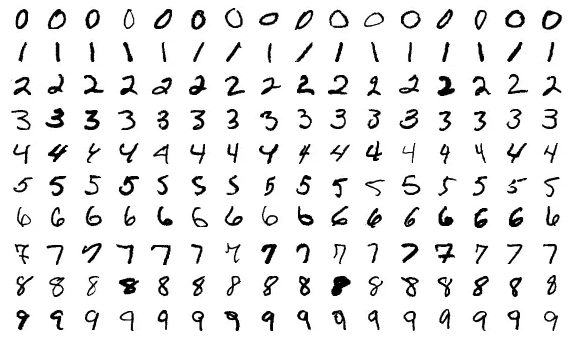

Importando a biblioteca do tensorflow. Tensorflow contém a biblioteca Keras que modela as imagens para redes neurais e também a própria base de dados que vamos utilizar nessa aula: https://keras.io/api/datasets/mnist/

O que são as redes adversárias gerativas? 🤔

As redes Adversárias Generativas possuem um grande potencial pois são capazes de gerar novos dados a partir de um conjunto de dados treinados. Podemos treinar essa rede para criar, por exemplo, novas imagens, músicas, falas, prosas, tratar resoluções de imagens e vídeos e muito mais. Uma das suas utilidades também pode ser criar novas imagens a partir de um conjunto de dados real para criar mais amostras de dados ao treinar uma rede neural convolucional.

Você já viu aquelas imagens fakes? Pois é, as redes GANs tem tanto o poder de criar dados fakes quanto validar a veracidade de dados. A rede GANs também é muito utilizada para recriar partes de imagens, por exemplo, se temos uma imagem de um cachorro pela metade, a rede tem o incrível poder de recriar. Falando ainda do uso da rede em imagens, a Pixar que é uma grande empresa que trabalha com animações utiliza muito as redes GANs para aumento de resolução de imagens. Para quem não conhece as redes Adversárias Generativas até parece mágica, não é mesmo?

Você aprendeu na aula de redes não supervisionadas que algoritmos discriminativos tentam criar classes ou grupos a partir de dados de entrada, ou seja, mapeiam recursos para criar rótulos utilizando correlação. Os algoritmos generativos fazem justamente o oposto, eles tentam prever os recursos (dados) com um determinado rótulo. Por exemplo, dado que um e-mail é classificado com spam, qual é a probabilidade de palavras que formam esse e-mail spam? Os algoritmos discriminativos se preocupam com a correlação entre x e y, modelos generativos se preocupam em “como você irá obter x”.

In [41]:
import tensorflow as tf
tf.__version__

'2.13.0'

In [61]:
# Bibliotecas fundamentais para a execução dessa rede
import os
import glob #gerar gif
import imageio #gerar gif
import matplotlib.pyplot as plt # gerar gráficos
import numpy as np # trabalhar com arrays
import PIL # manipular imagens
import tensorflow as tf
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, BatchNormalization
import time

from IPython import display

In [45]:
# Subindo a base de dados
(train_images, train_labels), (_,_) = tf.keras.datasets.mnist.load_data()

In [46]:
train_images = train_images.reshape(train_images.shape[0], 28, 28, 1).astype('float32') # definindo o tamaho da imagm (28x28) com 1 canal de cinza
train_images = (train_images - 127.5) / 127.5 # normalizando a imagem para -1, 1

In [47]:
BUFFER_SIZE = 60000 # tamanho do conjunto de dados
BACTH_SIZE = 256 # quantidade de pixels que varia

In [48]:
# criando a base de treinamento
# from_tensor_slices: imagens dentro de um tensor
train_dataset = tf.data.Dataset.from_tensor_slices(train_images).shuffle(BUFFER_SIZE).batch(BACTH_SIZE) #conjunto de dados + batch para normalizar os pixels

Basicamente as GANs são compostas por duas redes, a geradora e a discriminante. São chamadas de adversárias porque essas duas redes tentam “jogar” uma com a outra o tempo todo. A rede geradora tenta enganar a rede discriminante gerando dados fakes semelhantes aos dados reais.

O **objetivo da rede discriminate** aqui é reconhecer que os dígitos gerados a mão são o mais próximos possíveis dos verdadeiros números. A **rede geradora** tenta criar novas imagens fakes com a esperança de torná-las autênticas também (mesmo sendo falsas). O funcionamento da rede consiste nas seguintes etapas: O gerador considera números aleatórios e retornam uma imagem (ou seja, cria uma imagem fake); Essa imagem fake gerada pelo gerador é inserida no discriminador ao lado do fluxo de imagens verdadeiras geradas; o discriminador obtém imagens reais e falsas retornando a probabilidade realizando previsões de imagens falsas geradas pela rede generativa.


Vamos criar como próximo passo essas duas redes:


In [49]:
# criando o nosso modelo gerador

def make_generator_model():
  model = tf.keras.Sequential()
  model.add(layers.Dense(7*7*256, use_bias=False, input_shape=(100,)))
  model.add(layers.BatchNormalization())
  model.add(layers.LeakyReLU())

  model.add(layers.Reshape((7,7,256)))
  assert model.output_shape == (None, 7, 7, 256) # None é o batch size

  model.add(layers.Conv2DTranspose(128,(5, 5), strides=(1,1), padding='same', use_bias=False))
  assert model.output_shape == (None, 7, 7, 128)
  model.add(layers.BatchNormalization())
  model.add(layers.LeakyReLU())

  model.add(layers.Conv2DTranspose(64,(5, 5), strides=(2,2), padding='same', use_bias=False))
  assert model.output_shape == (None, 14, 14, 64)
  model.add(layers.BatchNormalization())
  model.add(layers.LeakyReLU())

  model.add(layers.Conv2DTranspose(1,(5, 5), strides=(2,2), padding='same', use_bias=False, activation='tanh'))
  assert model.output_shape == (None, 28, 28, 1)

  return model



Agora utilizando a função geradora de imagens, vamos ver o que ela pode criar de forma aleatória.

Criando a primeira imagem nunca treinada antes:

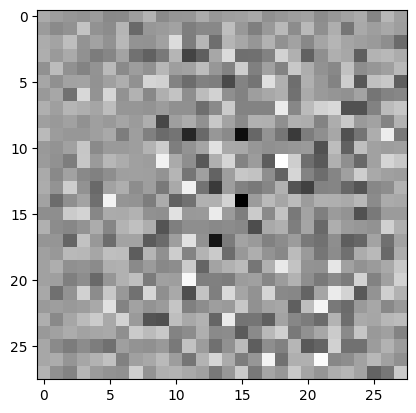

In [50]:
generator = make_generator_model()

noise = tf.random.normal([1, 100])
generator_image = generator(noise, training=False)

plt.imshow(generator_image[0, :, :, 0], cmap='gray')

Agora vamos criar a função do modelo discriminativo:

In [51]:
def make_discriminator_model():
  model = tf.keras.Sequential()
  model.add(layers.Conv2D(64, (5, 5), strides=(2,2), padding='same', input_shape=[28,28,1]))
  model.add(layers.LeakyReLU())
  model.add(layers.Dropout(0.3))

  model.add(layers.Conv2D(128, (5, 5), strides=(2,2), padding='same'))
  model.add(layers.LeakyReLU())
  model.add(layers.Dropout(0.3))

  model.add(layers.Flatten())
  model.add(layers.Dense(1))

  return model

In [52]:
discriminator = make_discriminator_model()
decision = discriminator(generator_image)
print(decision)

tf.Tensor([[0.00100151]], shape=(1, 1), dtype=float32)


O discriminador  acusou um valor positivo para essa imagem gerada de forma aleatória. Ou seja, considerou a imagem real.

Criar a rede Gans onde a cada época a imagem vai ser construída. Vamos a princípio configurar a função de custo e para essa solução vamos utilizar a Adam.

Relembrando, o Adam combina elementos do método do momento (momentum) e da média móvel exponencial para **ajustar as taxas de aprendizado de forma adaptativa** para cada parâmetro do modelo.


In [54]:
# configurando a função de custo (loss function)

cross_entropy = tf.keras.losses.BinaryCrossentropy(from_logits=False) # crio uma função loss

Cada modelo precisa ter sua função de custo parametrizada:

In [56]:
# função loss para o discriminador

def discriminator_loss(real_output, fake_output):
  real_loss = cross_entropy(tf.ones_like(real_output), real_output) # dado real # 1 verdadeiro
  fake_loss = cross_entropy(tf.zeros_like(fake_output), fake_output) # dado fake # 0 falso
  total_loss = real_loss + fake_loss # faz a comparação
  return total_loss

In [57]:
# avaliar fake gerado
def generator_loss(fake_output):
  return cross_entropy(tf.ones_like(fake_output ), fake_output) # dado fake apenas

In [59]:
# definindo o otimizador da função de custo Adam
generator_optimizer = tf.keras.optimizers.Adam(1e-4)
discriminator_optimizer = tf.keras.optimizers.Adam(1e-4)

Vamos criar um checkpoint para salvar o aprendizado do modelo. Você vai perceber que esses modelos de deep learning costumam demorar muito no aprendizado e processamento. Ter um checkpoint para salvar o aprendizado é uma boa dica!

In [63]:
# para salvar o modelo
checkpoint_dir = './training_checkpoints' #diretório para salvar pontos específicos de rede
checkpoint_prefix = os.path.join(checkpoint_dir, "ckpt")
checkpoint = tf.train.Checkpoint(generator_optimizer=generator_optimizer,
                               discriminator_optimizer=discriminator_optimizer,
                                generator=generator,
                                discriminator=discriminator)

Vamos definir as épocas de processamento:

In [64]:
EPOCHS = 50
noise_dim = 100
num_examples_to_generate = 16

seed = tf.random.normal([num_examples_to_generate, noise_dim])

Vamos criar uma função para acompanharmos a evolução da rede:

In [75]:
# criando uma função para mostrar a evolução dos passos de treinamento

def train_step(images): # recebe as imagens
  noiose = tf.random.normal([BACTH_SIZE, noise_dim])

  with tf.GradientTape() as gen_tape, tf.GradientTape() as disc_tape:
    generate_images = generator(noise, training=True)

    real_output = discriminator(images, training=True)
    fake_output = discriminator(generate_images, training=True)

    gen_loss = generator_loss(fake_output)
    disc_loss = discriminator_loss(real_output, fake_output)

  gradients_of_generator = gen_tape.gradient(gen_loss, generator.trainable_variables)
  gradientes_of_discriminator = disc_tape.gradient(disc_loss, discriminator.trainable_variables)

  generator_optimizer.apply_gradients(zip(gradients_of_generator, generator.trainable_variables))
  discriminator_optimizer.apply_gradients(zip(gradientes_of_discriminator, discriminator.trainable_variables))


Como próximo passo, vamos criar a função responsável por treinar a rede!
Nessa função vamos utilizar o checkpoint para salvar o processamento da rede e vamos utilizar a função generate_and_save_images (que será criada logo em seguida) para gerar as imagens processadas pela rede.

In [76]:
# criando a função de treino da rede

def train(dataset, epochs):
  for epoch in range(epochs):
    start = time.time()

    for image_batch in dataset:
      train_step(image_batch)

      # cria o gif
      display.clear_output(wait=True)
      generate_and_save_images = (generator,
                                  epoch + 1,
                                  seed)

      # salva o modelo a cada 15 épocas de procesamento
      if(epoch + 1) % 15 == 0:
        checkpoint.save(file_prefix = checkpoint_prefix)

      print('Tempo para a época {} é {} sec'.format(epoch + 1, time.time()-start))

    # Gerador após a época final
    display.clear_output(wait=True)
    generate_and_save_images = (generator,
                                  epoch + 1,
                                  seed)

In [77]:
# função para definir as imagens

def generate_and_save_images(model, epoch, test_input):
  predictions = model(test_input, training=False)

  fig = plt.figure(figsize=(4,4))

  for i in range(predictions.shape[0]):
    plt.subplot(4, 4, i+1)
    plt.imshow(predictions[i, :, :, 0] * 127.5 + 127.5, cmap='gray')
    plt.axis('off')

  plt.savefig('imagem_epoch_{:04d}.png'.fomrat(epoch))
  plt.show

E vamos treinar essa rede?

Você vai notar que o tempo de processamento dessa rede neural é muito longo, a minha aqui deu aproximadamente 2 horas 😯

Por isso é importante ter os checkpoints definido!

In [78]:
train(train_dataset, EPOCHS)

Tempo para a época 50 é 175.30645728111267 sec
